In [1]:
from pathlib import Path
import pandas as pd

In [2]:
def change_name(name):

    rule = {
        'SSP126': 'ssp126',
        'SSP585': 'ssp585',
        'MA': 'meanAnt',
        'PIGL5th': 'PIG5',
    }

    if name in rule.keys():
        return rule[name]
    else:
        return name

def convert(df: pd.DataFrame) -> pd.DataFrame:

    df = df.iloc[:-2]
    years = list(map(int, df['Year']))
    # transpose
    df = df.T.iloc[1:]
    df = df.reset_index()
    df.columns = ['index', *years]

    run_info = df['index'].str.split('_', expand=True)
    df[['scenario', 'gcm', 'slidinglaw', 'gamma']] = run_info
    df = df.drop(columns=['index'])

    df = df[['gamma', 'scenario', 'gcm', 'slidinglaw', *years]]

    for column in ['gamma', 'scenario', 'gcm', 'slidinglaw']:
        df[column] = df[column].apply(change_name)
    return df

In [3]:
mypath = Path('/Users/jonniebarnsley/code/phd/local/data/overshoot')
mirapath = Path('/Users/jonniebarnsley/code/phd/local/data/ssp/mira')

for file in sorted(mirapath.iterdir()):
    if file.name.startswith('.'):
        continue
    df = pd.read_csv(file)
    break

df.head()

,gamma,scenario,gcm,slidinglaw,2007,2008,2009,2010,2011,2012,...,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300
0,meanAnt,ssp126,CESM2-WACCM,J300,0.0,0.000188,0.001074,0.001770,0.002573,0.003437,...,0.069151,0.069360,0.069680,0.069817,0.069941,0.070027,0.070052,0.070299,NaN,NaN
1,meanAnt,ssp126,CESM2-WACCM,J50,0.0,-0.000370,0.000222,0.000579,0.001026,0.001489,...,0.035840,0.036276,0.036835,0.037220,0.037624,0.037979,0.038278,0.038787,NaN,NaN
2,meanAnt,ssp126,CESM2-WACCM,WT,0.0,0.001136,0.002561,0.003779,0.005092,0.006433,...,0.125754,0.126168,0.126700,0.127054,0.127424,0.127751,0.128011,0.128469,NaN,NaN
3,meanAnt,ssp126,UKESM1-0-LL,J300,0.0,0.000771,0.001629,0.002278,0.003204,0.004049,...,0.031138,0.031155,0.031039,0.030757,0.030820,0.030971,0.030596,0.030133,0.030212,0.030479
4,meanAnt,ssp126,UKESM1-0-LL,J50,0.0,0.000230,0.000788,0.001106,0.001664,0.002144,...,-0.034459,-0.034552,-0.034790,-0.035176,-0.035218,-0.035176,-0.035652,-0.036207,-0.036216,-0.036052


In [5]:
dataframes = []
for csv in sorted(mirapath.iterdir())[2:]:
    df = pd.read_csv(csv)
    dataframes.append(df)

combined_df = dataframes[0].copy()
years = list(range(2007, 2301))
for df in dataframes[1:]:
    numerical_columns = combined_df.select_dtypes(include=['float64', 'int64']).columns
    combined_df[numerical_columns] += df[numerical_columns]

combined_df.tail()

,gamma,scenario,gcm,slidinglaw,2007,2008,2009,2010,2011,2012,...,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300
31,PIG5,collapse,CESM2-WACCM,J50,0.0,0.000021,0.000950,0.001633,0.002302,0.003023,...,2.221595,2.234224,2.246395,2.258732,2.271558,2.284218,2.297214,2.310824,2.323761,2.336050
32,PIG5,collapse,CESM2-WACCM,WT,0.0,0.001555,0.003337,0.004817,0.006235,0.007745,...,1.877906,1.888830,1.899274,1.909396,1.920053,1.930180,1.939734,1.949569,1.958981,1.968139
33,PIG5,collapse,UKESM1-0-LL,J300,0.0,0.000856,0.001780,0.002515,0.003476,0.004322,...,1.667161,1.674070,1.679817,1.685240,1.691226,1.696299,1.701395,1.707029,1.712426,1.717175
34,PIG5,collapse,UKESM1-0-LL,J50,0.0,0.000360,0.000990,0.001407,0.002022,0.002512,...,2.150525,2.157650,2.163867,2.170477,2.178713,2.186526,2.194295,2.202342,2.210164,2.217296
35,PIG5,collapse,UKESM1-0-LL,WT,0.0,0.001807,0.003317,0.004564,0.006022,0.007352,...,1.836960,1.845358,1.852669,1.859964,1.867716,1.874453,1.881307,1.889029,1.896821,1.904412


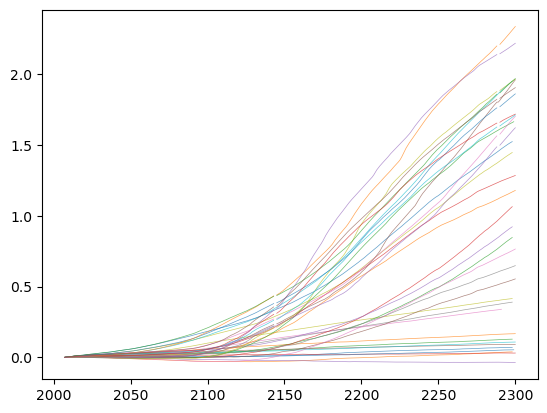

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for i, row in combined_df.iterrows():
    slc = row[numerical_columns]
    ax.plot(range(2007, 2301), slc, lw=0.5, alpha=0.7)

In [7]:
combined_df.to_csv(mirapath / 'total_basin_00.csv', index=False)

In [11]:
myfiles = sorted(mypath.iterdir())[1:]
mirafiles = sorted(mirapath.iterdir())[1:]
for mycsv, miracsv in zip(myfiles, mirafiles):
    mydf = pd.read_csv(mycsv)
    miradf = pd.read_csv(miracsv)
    df = pd.concat([miradf, mydf], ignore_index=True)
    name = mycsv.name.split('_')[0]+'.csv'
    df.to_csv(mypath / 'zwally_v5' / name)

In [15]:
path = mypath / 'zwally_v5' / 'ZWALLY00.csv'
df = pd.read_csv(path)
df

,Unnamed: 0,gamma,scenario,gcm,slidinglaw,2007,2008,2009,2010,2011,...,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300
0,0,meanAnt,ssp126,CESM2-WACCM,J300,0.0,0.000188,0.001074,0.001770,0.002573,...,0.069151,0.069360,0.069680,0.069817,0.069941,0.070027,0.070052,0.070299,NaN,NaN
1,1,meanAnt,ssp126,CESM2-WACCM,J50,0.0,-0.000370,0.000222,0.000579,0.001026,...,0.035840,0.036276,0.036835,0.037220,0.037624,0.037979,0.038278,0.038787,NaN,NaN
2,2,meanAnt,ssp126,CESM2-WACCM,WT,0.0,0.001136,0.002561,0.003779,0.005092,...,0.125754,0.126168,0.126700,0.127054,0.127424,0.127751,0.128011,0.128469,NaN,NaN
3,3,meanAnt,ssp126,UKESM1-0-LL,J300,0.0,0.000771,0.001629,0.002278,0.003204,...,0.031138,0.031155,0.031039,0.030757,0.030820,0.030971,0.030596,0.030133,0.030212,0.030479
4,4,meanAnt,ssp126,UKESM1-0-LL,J50,0.0,0.000230,0.000788,0.001106,0.001664,...,-0.034459,-0.034552,-0.034790,-0.035176,-0.035218,-0.035176,-0.035652,-0.036207,-0.036216,-0.036052
5,5,meanAnt,ssp126,UKESM1-0-LL,WT,0.0,0.001726,0.003157,0.004300,0.005680,...,0.091200,0.091315,0.091282,0.091096,0.091263,0.091516,0.091235,0.090867,0.091049,0.091423
6,6,PIG5,ssp126,CESM2-WACCM,J300,0.0,0.000188,0.001059,0.001752,0.002491,...,0.339527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,PIG5,ssp126,CESM2-WACCM,J50,0.0,-0.000370,0.000187,0.000523,0.000886,...,0.378512,0.380075,0.381833,0.383353,0.384966,0.386480,0.387953,0.389730,NaN,NaN
8,8,PIG5,ssp126,CESM2-WACCM,WT,0.0,0.001136,0.002622,0.003911,0.005216,...,0.405720,0.407098,0.408660,0.409951,0.411272,0.412492,0.413649,0.415111,NaN,NaN
9,9,PIG5,ssp126,UKESM1-0-LL,J300,0.0,0.000771,0.001632,0.002288,0.003194,...,0.105530,0.105882,0.106119,0.106216,0.106641,0.107123,0.107087,0.107013,0.107478,0.108110
